In [1]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba
import plot_methods as plot

import numpy as np

### **Dubin's car** 

In this experiement, $x_0$ follows a Gaussian distribution ($x_0 \sim \mathcal{N}(\mu_{0}, \Sigma_{0})$), and the system is polynomial following XXX.

We aim to compute GMM approximations $\hat{p}(x_t)$ for $5$ time steps, as well as bounds on their TV distances to the true distributions $p(x_t)$.

**Numerical note**: The theory related to this experiement does NOT demand that those Gaussians should have uncorrelated components. However, our current code implementation does assume that.

##### 1) Defining system parameters

In [2]:
METHOD = 'dubin'

h = 0.3
v = 5
u = 1/0.5

params = [h, v, u]

In [3]:
#Initial distribution
sigma = 0.005

mean_initial_state = np.array([1.0, 1.0, 0.0])
var_initial_state = np.array([sigma, sigma, 0.001]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Noise structure
sigma_noise = 0.001

mean_noise = [0, 0, 0]
var_noise = np.array([sigma_noise, sigma_noise, 0.0001]) #Assumes uncorrelation (this could be relaxed in further upgrades)

#Steps ahead for prediction
n_steps_ahead = 8

In [4]:
unbounded_region = np.array([[np.inf, np.inf, np.inf], [np.inf, np.inf, np.inf]]) #a representation choice for the unbounded region

In [5]:
colors = ['Purples', 'Blues', 'Oranges', 'YlOrBr', 'YlOrRd', 
          'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 
          'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

##### 2) Monte Carlo simulation of the system

We run a MC simulation for the system above in order to understand its (probabilistic) behavior.

Note: We also add a representation for an unsafe set (red square) which will later motivate safety discussions.

In [6]:
barriers_list = barriers.createBarrier(np.array([[20, 1.5, -np.inf], [21, 3.5, np.inf]]))
barrier = barriers_list[0]

In [7]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_19328\2522582876.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0
Hitting proba: 0.0


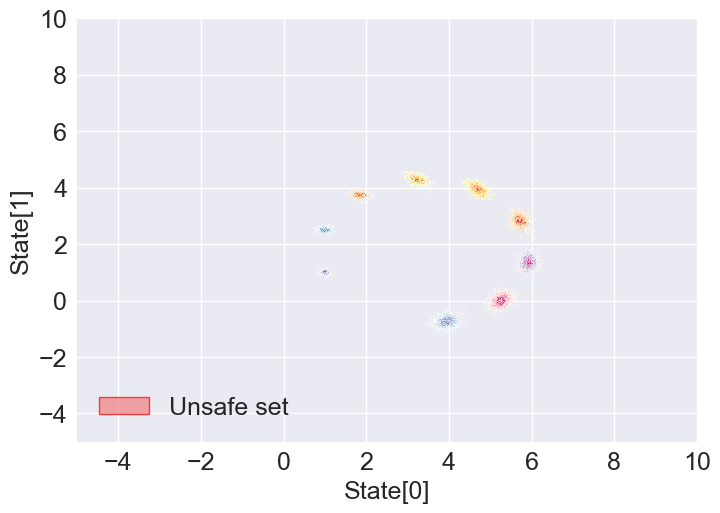

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

n_simulations = 10_000
mc_hitting_proba = []

fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):
    if t == 0:
        states = propag.getInitialState(mean_initial_state, var_initial_state, n_simulations)
    else:
        states = propag.stateOneStepEvolution(states, mean_noise, var_noise, METHOD, params)
    
    #Plot samples
    plt.hist2d(states[:, 0], states[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    #Compute hitting probability
    hitting_proba = barriers.hittingProbabilityMC(states, barrier)
    mc_hitting_proba.append(hitting_proba)

plt.legend(loc='lower left', fontsize="18")
plt.tick_params(labelsize=18)

plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.xlabel('State[0]', fontsize=18)
plt.ylabel('State[1]', fontsize=18)
plt.grid(True)
plt.show()

In [9]:
refinements = [1e-6, 1e-7, 5e-7, 5e-7, 5e-6, 4e-6, 3e-6, 4e-6, 4e-6, 4e-6]

Function 'computeSignatureProbabilitiesInParallel' executed in 0.8168s
Number of regions:  380
TV bound at propag step: 0.6983296893321165
Function 'computeSignatureProbabilitiesInParallel' executed in 0.8516s
Number of regions:  3033
TV bound at propag step: 0.44067261822572995
0.0
Function 'computeSignatureProbabilitiesInParallel' executed in 0.9505s
Number of regions:  331
TV bound at propag step: 0.6878914886386054
Function 'computeSignatureProbabilitiesInParallel' executed in 1.3924s
Number of regions:  2613
TV bound at propag step: 0.43552111776723224
0.0
Function 'computeSignatureProbabilitiesInParallel' executed in 0.9029s
Number of regions:  380
TV bound at propag step: 0.7131201996198486
Function 'computeSignatureProbabilitiesInParallel' executed in 1.4997s
Number of regions:  2977
TV bound at propag step: 0.4455144940067845
0.0
Function 'computeSignatureProbabilitiesInParallel' executed in 0.8789s
Number of regions:  387
TV bound at propag step: 0.7392652669486867
Function '

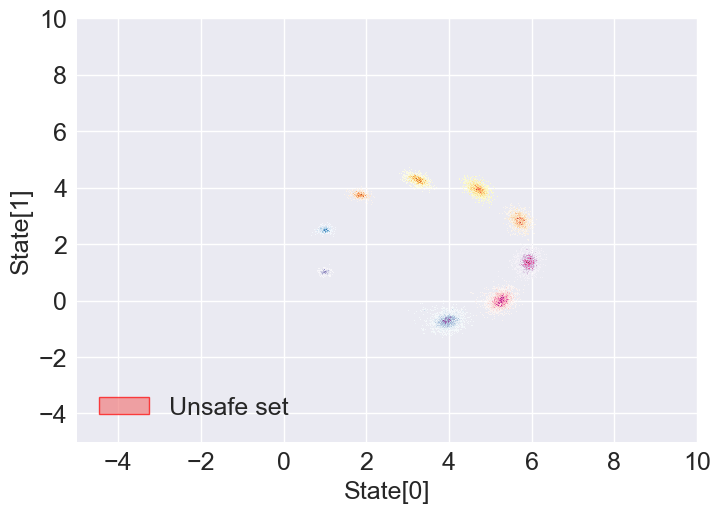

In [10]:
n_samples = 10_000

min_proportion = 0.01
min_size = 0.002
n_refinements = 1

tv_bounds = [0.0]
gmm_hitting_proba = [0.0]


fig, ax = plt.subplots()

rect = Rectangle(barrier[0], barrier[1][0] - barrier[0][0], barrier[1][1] - barrier[0][1], 
                    edgecolor = 'red', facecolor = 'lightcoral', fill=True, lw=1, alpha=0.7, label = 'Unsafe set')
ax.add_patch(rect)

for t in range(n_steps_ahead + 1):

    if t == 0:
        hat_gmm = [np.array([1.0]), np.array([mean_initial_state]), var_initial_state]
    else:
        means_gmm = propag.propagateSignatures(signatures, METHOD, params)
        hat_gmm = [double_hat_proba, means_gmm, var_noise]

        #Compute hitting probability
        proba_barrier = proba.gmmProbabilityMassInsideRegion(double_hat_proba, means_gmm, var_noise, barrier)
        gmm_hitting_proba.append(proba_barrier)


    samples = propag.sampleFromGMM(n_samples, hat_gmm[0], hat_gmm[1], hat_gmm[2])
    plt.hist2d(samples[:, 0], samples[:, 1], bins=100, cmap=colors[t], alpha=0.8, cmin=0.1)

    if t < n_steps_ahead:

        vertice_lower, vertice_upper = grid.findMinMaxPoints(samples)

        hpr = np.array([vertice_lower, vertice_upper])

        outer_signature = grid.computeOuterPoint(hpr)

        regions = np.array(grid.subdivideRegion(hpr, samples, min_proportion, min_size))

        signatures = grid.placeSignatures(regions)

        double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])

        regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
        print('Number of regions: ', len(regions))

        tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)

        for r in range(n_refinements):


            regions, signatures = grid.refineRegions(regions, signatures, contributions, refinements[r])
            regions = regions[:-1]
            signatures = signatures[:-1]
            double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, hat_gmm[1], hat_gmm[2], hat_gmm[0])
            regions, signatures = grid.addUnboundedRepresentations(regions, unbounded_region, signatures, outer_signature)
            print('Number of regions: ', len(regions))

            tv_bound, contributions = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, var_noise, METHOD, params)

        tv_bounds.append(tv_bound)

plt.legend(loc='lower left', fontsize="18")
plt.tick_params(labelsize=18)

plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.xlabel('State[0]', fontsize=18)
plt.ylabel('State[1]', fontsize=18)
plt.grid(True)
plt.show()

In [11]:
tv_bounds_cumul = np.cumsum(tv_bounds)
tv_bounds_cumul

array([0.        , 0.44067262, 0.87619374, 1.32170823, 1.79260045,
       2.30621615, 2.8303732 , 3.38095524, 3.9593038 ])

##### TV contribution per region

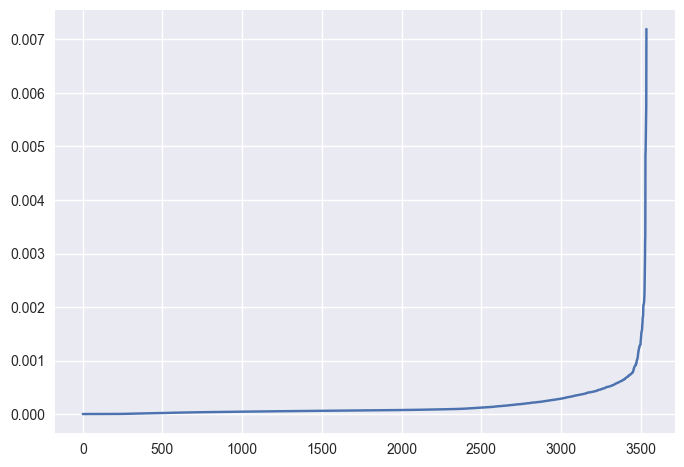

In [12]:
contributions = np.array(contributions)
contributions = np.sort(contributions)
plt.plot(contributions)

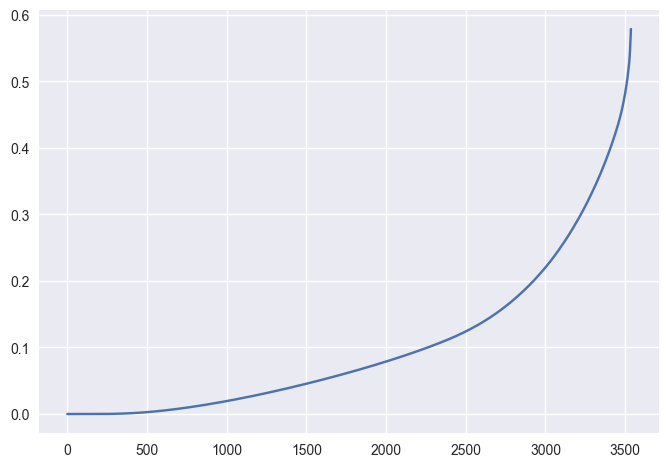

In [13]:
plt.plot(np.cumsum(contributions))

In [14]:
import matplotlib.pyplot as plt

def draw_square(x_min, y_min, x_max, y_max):
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='blue')

def plot_regions(regions):
    for region in regions:
        x_min, y_min, z_min = region[0]
        x_max, y_max, z_max = region[1]
        draw_square(x_min, y_min, x_max, y_max)
    plt.xlabel('State[0]')
    plt.ylabel('State[1]')
    plt.grid(True)
    plt.axis('equal')  # Set equal aspect ratio
    plt.show()

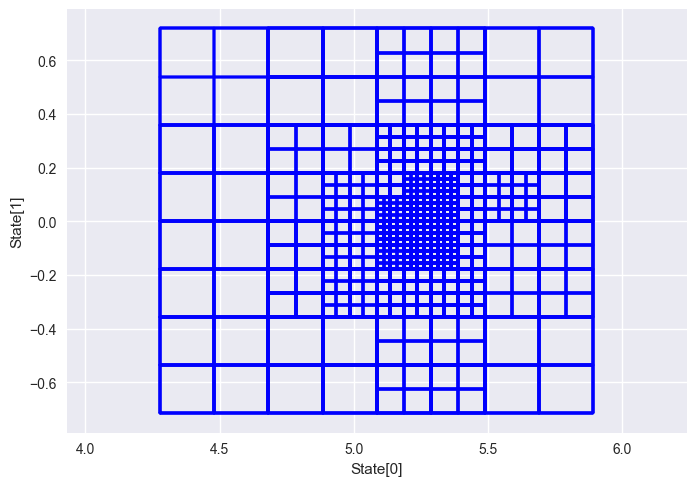

In [15]:
plot_regions(regions)

Plot grid 3D

In [16]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def draw_cube(ax, x_min, y_min, z_min, x_max, y_max, z_max):
#     # Define vertices of the cube
#     vertices = [
#         [x_min, y_min, z_min],
#         [x_min, y_max, z_min],
#         [x_max, y_max, z_min],
#         [x_max, y_min, z_min],
#         [x_min, y_min, z_max],
#         [x_min, y_max, z_max],
#         [x_max, y_max, z_max],
#         [x_max, y_min, z_max]
#     ]

#     # Define the edges of the cube
#     edges = [
#         [vertices[0], vertices[1], vertices[2], vertices[3], vertices[0]],
#         [vertices[4], vertices[5], vertices[6], vertices[7], vertices[4]],
#         [vertices[0], vertices[4]],
#         [vertices[1], vertices[5]],
#         [vertices[2], vertices[6]],
#         [vertices[3], vertices[7]]
#     ]

#     # Plot each edge
#     for edge in edges:
#         x, y, z = zip(*edge)
#         ax.plot(x, y, z, color='blue')


# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot each cube
# for region in regions:
#     draw_cube(ax, region[0][0], region[0][1], region[0][2], region[1][0], region[1][1], region[1][2])

# # Set plot labels
# ax.set_xlabel('State[0]')
# ax.set_ylabel('State[1]')
# ax.set_zlabel('State[2]')

# # Show plot
# plt.show()

##### Compare hitting probabilities

C:\Users\efigueiredomot\AppData\Local\Temp\ipykernel_19328\1702447121.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


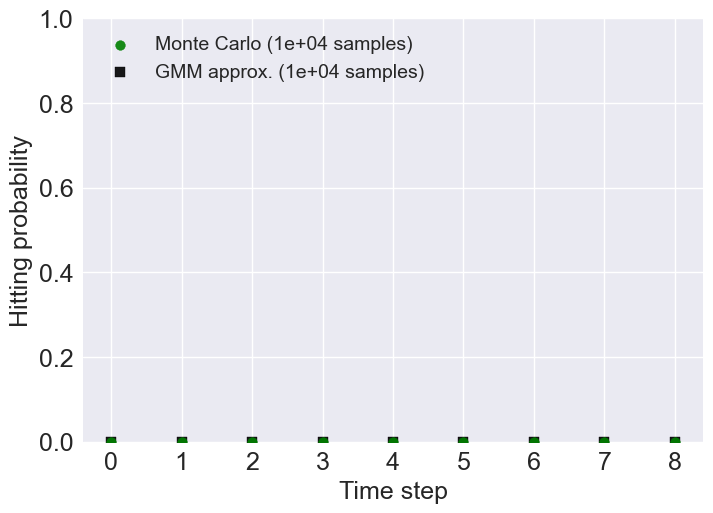

In [17]:
#Compute TV bounds
tv_bounds_cumul = np.cumsum(tv_bounds)

plt.style.use("seaborn")

# Plotting
plt.scatter(range(len(mc_hitting_proba)), mc_hitting_proba, color='green', alpha = 0.9, label = f'Monte Carlo ({n_simulations:.0e} samples)', zorder=3)
plt.scatter(range(len(gmm_hitting_proba)), gmm_hitting_proba, color='black', alpha = 0.9, marker='s', label = f'GMM approx. ({n_samples:.0e} samples)', zorder=2)

# Adding error bars for gmm_probas
#plt.errorbar(range(len(gmm_hitting_proba)), gmm_hitting_proba, yerr = tv_bounds_cumul, fmt='none', color='black', alpha = 0.9, capsize=5, label='TV bounds', zorder=1)

plt.ylim(0, 1)
plt.xticks(range(len(mc_hitting_proba)))

plt.tick_params(labelsize=18)
plt.xlabel('Time step', fontsize=18)
plt.ylabel('Hitting probability', fontsize=18)
plt.legend(loc='upper left', fontsize="14")
plt.show()

In [18]:
mc_hitting_proba

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [19]:
gmm_hitting_proba

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]